In [1]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import corner

import retrieval_base.auxiliary_functions as af

def plot_hist1d(ax, posterior, ec, fc, xrange, bins=25, ls='-', ymarker=0.05, sigma_to_plot=1, label=None):

    q = np.array([0.5-0.997/2, 0.5-0.95/2, 0.5-0.68/2, 0.5, 0.5+0.68/2, 0.5+0.95/2, 0.5+0.997/2])

    _, _, p = ax.hist(
        posterior, bins=bins, range=xrange, histtype='step', fill=True, 
        ec=ec, fc=fc, ls=ls, label=label, 
        )

    idx = [2,-3]
    if sigma_to_plot == 2:
        idx = [1,-2]
    elif sigma_to_plot == 3:
        idx = [0,-1]

    median = np.median(posterior)
    xerr = np.abs(np.quantile(posterior, q=q[idx])-median)[:,None]
    ax.errorbar(
        median, ymarker, xerr=xerr, 
        fmt='o', c=ec, capthick=2, elinewidth=2, markersize=4, 
        transform=ax.get_xaxis_transform(), #zorder=10
        )

    xerr = np.abs(np.quantile(posterior, q=q[idx])-median)[:,None]
    print('{:} | -{:} +{:}'.format(median, *xerr.flatten()))

    return p[0], median, xerr

In [2]:
#res = af.read_results('./retrieval_outputs/order_6_A_ret_1/test_', n_params=27)
res = af.read_results('./retrieval_outputs/fiducial_K_A_ret_1/test_', n_params=33)
posterior_A, bestfit_A, PT_A, Chem_A, int_contr_em_A, int_contr_em_per_order_A, int_opa_cloud_A, m_spec_A, d_spec_A, LogLike_A, Cov_A, bestfit_params_A = res
del res

res = af.read_results('./retrieval_outputs/order_6_B_ret_1/test_', n_params=27)
posterior_B, bestfit_B, PT_B, Chem_B, int_contr_em_B, int_contr_em_per_order_B, int_opa_cloud_B, m_spec_B, d_spec_B, LogLike_B, Cov_B, bestfit_params_B = res
del res

  analysing data from ./retrieval_outputs/fiducial_K_A_ret_1/test_.txt
  analysing data from ./retrieval_outputs/order_6_B_ret_1/test_.txt


In [3]:
def get_colors(color):

    envelope_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        name='envelope_cmap', colors=[color, color], 
        )
    envelope_colors = envelope_cmap([0.0,0.2,0.4,0.6,0.8])
    envelope_colors[:,-1] = np.array([0.0,0.2,0.4,0.6,0.8])

    return envelope_colors, color

env_color_A, color_A = get_colors('purple')
env_color_B, color_B = get_colors('darkorange')

98.15386651652858 | -4.1827893164942225 +4.965149373284149
64.20177460478585 | -4.350691086601756 +4.709641175631148
0.703910017452116 | -0.003253218279684833 +0.0031095108435821306
0.6778258754594944 | -0.005783620762469854 +0.004952782770808795
0.2335827458542377 | -0.01384573289710525 +0.012649960366227703
-0.3319423820174052 | -0.02609132626513022 +0.030389531482432952
59693.83063188389 | -53566.61643674134 +545988.138755838
782.5516197685599 | -295.61310246744927 +1169.7295162409569


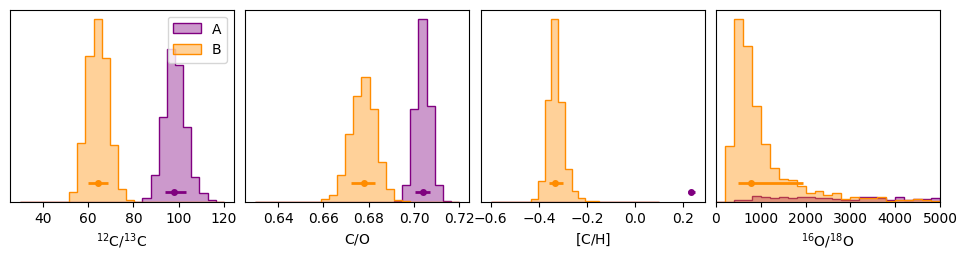

In [4]:
Chem_A.C_ratio_posterior = 10**posterior_A[:,10] / 10**posterior_A[:,14]
Chem_B.C_ratio_posterior = 10**posterior_B[:,10] / 10**posterior_B[:,14]

Chem_A.O_ratio_posterior = 10**posterior_A[:,10] / 10**posterior_A[:,15]
Chem_B.O_ratio_posterior = 10**posterior_B[:,10] / 10**posterior_B[:,15]

fig, ax = plt.subplots(
    figsize=(12,2.5), ncols=4, gridspec_kw={'wspace':0.05}
    )

plot_hist1d(
    ax[0], Chem_A.C_ratio_posterior, ec=color_A, fc=env_color_A[2], xrange=(30,120), label='A'
    )
plot_hist1d(
    ax[0], Chem_B.C_ratio_posterior, ec=color_B, fc=env_color_B[2], xrange=(30,120), ymarker=0.1, label='B'
    )

plot_hist1d(
    ax[1], Chem_A.CO_posterior, ec=color_A, fc=env_color_A[2], xrange=(0.63,0.72)
    )
plot_hist1d(
    ax[1], Chem_B.CO_posterior, ec=color_B, fc=env_color_B[2], xrange=(0.63,0.72), ymarker=0.1
    )

plot_hist1d(
    ax[2], Chem_A.FeH_posterior, ec=color_A, fc=env_color_A[2], xrange=(-0.6,0.1)
    )
plot_hist1d(
    ax[2], Chem_B.FeH_posterior, ec=color_B, fc=env_color_B[2], xrange=(-0.6,0.1), ymarker=0.1
    )

plot_hist1d(
    ax[3], Chem_A.O_ratio_posterior, ec=color_A, fc=env_color_A[2], xrange=(0,5000)
    )
plot_hist1d(
    ax[3], Chem_B.O_ratio_posterior, ec=color_B, fc=env_color_B[2], xrange=(0,5000), ymarker=0.1
    )

ax[0].legend(loc='upper right')

ax[0].set(yticks=[], xlabel=r'$\mathrm{^{12}C/^{13}C}$')
ax[1].set(yticks=[], xlabel=r'$\mathrm{C/O}$')
ax[2].set(yticks=[], xlabel=r'$\mathrm{[C/H]}$')
ax[3].set(yticks=[], xlabel=r'$\mathrm{^{16}O/^{18}O}$', xlim=(0,5000))

#Chem_wo_GPs.C_ratio_posterior = 10**posterior_wo_GPs[:,10] / 10**posterior_wo_GPs[:,12]
#posterior_1[]
plt.show()

0.9213048985625941 | -0.006241703482368521 +0.006522254008239359
0.9463164007239511 | -0.01567806409376382 +0.014331723293078746
4.846388421449852 | -0.020438986677503657 +0.01718512062516009
4.486550536367091 | -0.044141014205020035 +0.048611594177918604
17.244165446547193 | -0.01543701763313976 +0.015173864522576963
19.61661050015245 | -0.05353687525944295 +0.054489887270150916
14.907019046427179 | -0.05565911436812421 +0.05702651540223691
26.332242886642913 | -0.09752470093817678 +0.10058826871503967
0.6178757817927463 | -0.020799646604087063 +0.02273514298560131
0.9889143119963226 | -0.010243092172800505 +0.007436820049518067


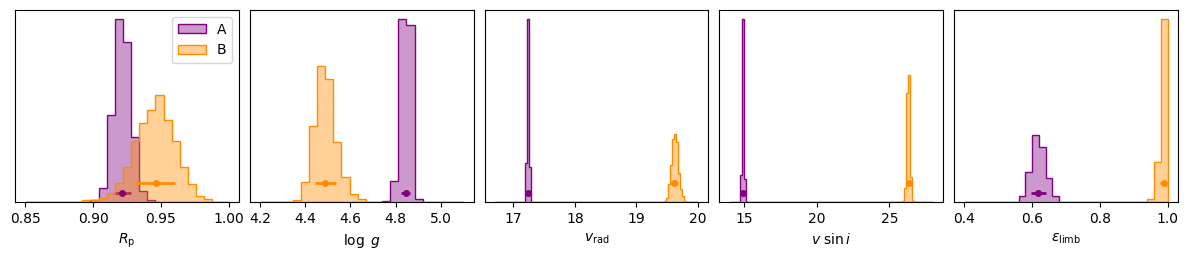

In [5]:
fig, ax = plt.subplots(
    figsize=(15,2.5), ncols=5, gridspec_kw={'wspace':0.05}
    )

plot_hist1d(
    ax[0], posterior_A[:,2], ec=color_A, fc=env_color_A[2], xrange=(0.85,1.), label='A'
    )
plot_hist1d(
    ax[0], posterior_B[:,2], ec=color_B, fc=env_color_B[2], xrange=(0.85,1.), ymarker=0.1, label='B'
    )

plot_hist1d(
    ax[1], posterior_A[:,3], ec=color_A, fc=env_color_A[2], xrange=(4.2,5.1)
    )
plot_hist1d(
    ax[1], posterior_B[:,3], ec=color_B, fc=env_color_B[2], xrange=(4.2,5.1), ymarker=0.1
    )

plot_hist1d(
    ax[2], posterior_A[:,6], ec=color_A, fc=env_color_A[2], xrange=(16.7,20), bins=100
    )
plot_hist1d(
    ax[2], posterior_B[:,6], ec=color_B, fc=env_color_B[2], xrange=(16.7,20), bins=100, ymarker=0.1
    )

plot_hist1d(
    ax[3], posterior_A[:,5], ec=color_A, fc=env_color_A[2], xrange=(14,28), bins=100
    )
plot_hist1d(
    ax[3], posterior_B[:,5], ec=color_B, fc=env_color_B[2], xrange=(14,28), bins=100, ymarker=0.1
    )

plot_hist1d(
    ax[4], posterior_A[:,4], ec=color_A, fc=env_color_A[2], xrange=(0.4,1), bins=30
    )
plot_hist1d(
    ax[4], posterior_B[:,4], ec=color_B, fc=env_color_B[2], xrange=(0.4,1), bins=30, ymarker=0.1
    )

ax[0].legend(loc='upper right')

ax[0].set(yticks=[], xlabel=r'$R_\mathrm{p}$')
ax[1].set(yticks=[], xlabel=r'$\log\ g$')
ax[2].set(yticks=[], xlabel=r'$v_\mathrm{rad}$')
ax[3].set(yticks=[], xlabel=r'$v\ \sin i$')
ax[4].set(yticks=[], xlabel=r'$\varepsilon_\mathrm{limb}$')

#Chem_wo_GPs.C_ratio_posterior = 10**posterior_wo_GPs[:,10] / 10**posterior_wo_GPs[:,12]
#posterior_1[]
plt.show()

In [22]:
from petitRADTRANS import Radtrans
import petitRADTRANS.nat_cst as nc
from PyAstronomy import pyasl
from scipy.ndimage import gaussian_filter, generic_filter

def opa_cross_sections(
        species, 
        species_mass, 
        T=1500, 
        P=1e-1, 
        epsilon_limb=0.65, 
        vsini=15, 
        rv=17, 
        out_res=1e5, 
        #wlen_bords_micron=[2.32,2.37]
        #wlen_bords_micron=[1.9,2.5]
        wlen_bords_micron=[1.0,5.0]
        ):

    pRT_atm = Radtrans(
        line_species=[species], wlen_bords_micron=wlen_bords_micron, mode='lbl'
        )
    res = pRT_atm.plot_opas(
        species=[species], temperature=T, pressure_bar=P, return_opacities=True
        )
    opa = res[species][1].flatten() * (species_mass*1.66053892e-24)

    wave = (nc.c / pRT_atm.freq * 1e7) 
    wave = wave * (1 + rv/(nc.c*1e-5))

    wave_even = np.linspace(wave.min(), wave.max(), wave.size)

    opa_even = np.interp(wave_even, xp=wave, fp=opa)
    opa_rot_broad = pyasl.fastRotBroad(
        wave_even, opa_even, epsilon=epsilon_limb, vsini=vsini
        )
    opa_rot_broad = instr_broadening(wave_even, opa_rot_broad, out_res=out_res, in_res=1e6)

    return wave_even, opa_rot_broad

def instr_broadening(wave, flux, out_res=1e6, in_res=1e6):

    # Delta lambda of resolution element is FWHM of the LSF's standard deviation
    sigma_LSF = np.sqrt(1/out_res**2 - 1/in_res**2) / \
                (2*np.sqrt(2*np.log(2)))

    spacing = np.mean(2*np.diff(wave) / (wave[1:] + wave[:-1]))

    # Calculate the sigma to be used in the gauss filter in pixels
    sigma_LSF_gauss_filter = sigma_LSF / spacing
    
    # Apply gaussian filter to broaden with the spectral resolution
    flux_LSF = gaussian_filter(flux, sigma=sigma_LSF_gauss_filter, 
                                mode='nearest'
                                )
    return flux_LSF

In [23]:
'''
import struct

def read_bin_single(filename):
    """ Read a binary opacity world file.
    """

    # Open file
    file = open(filename,mode='rb')
    # Read content
    cont = file.read()
    file.close()

    # The number of bytes per entry is 4
    # Get the number of datapoints
    points = int(len(cont)/4)
    # Create array of the appropriate length
    x = np.ones(points)

    # Read the binary data into the array
    for i in range(int(points)):
        test = struct.unpack('f',cont[i*4:(i+1)*4])
        x[i] = test[0]

    # Wavenumber points from range given in the file names
    wl_start = int(filename.split('/')[-1].split('_')[1])
    wl_end = int(filename.split('/')[-1].split('_')[2])
    wlen = np.linspace(wl_start, wl_end, len(opa))
    # Convert to cm or [micron]
    wavelength = 1./wlen#/1e-4
    
    return x[::-1], wavelength[::-1]

opa, wavelength = read_bin_single('/home/sam/Documents/PhD/CRIRES_data_reduction/pRT_data/input_data/opacities/lines/line_by_line/1H-19F__Coxon-Hajig_e2b/Out_00000_33000_01200_n100.bin')

print(opa)
'''

'\nimport struct\n\ndef read_bin_single(filename):\n    """ Read a binary opacity world file.\n    """\n\n    # Open file\n    file = open(filename,mode=\'rb\')\n    # Read content\n    cont = file.read()\n    file.close()\n\n    # The number of bytes per entry is 4\n    # Get the number of datapoints\n    points = int(len(cont)/4)\n    # Create array of the appropriate length\n    x = np.ones(points)\n\n    # Read the binary data into the array\n    for i in range(int(points)):\n        test = struct.unpack(\'f\',cont[i*4:(i+1)*4])\n        x[i] = test[0]\n\n    # Wavenumber points from range given in the file names\n    wl_start = int(filename.split(\'/\')[-1].split(\'_\')[1])\n    wl_end = int(filename.split(\'/\')[-1].split(\'_\')[2])\n    wlen = np.linspace(wl_start, wl_end, len(opa))\n    # Convert to cm or [micron]\n    wavelength = 1./wlen#/1e-4\n    \n    return x[::-1], wavelength[::-1]\n\nopa, wavelength = read_bin_single(\'/home/sam/Documents/PhD/CRIRES_data_reduction/pRT_d

In [24]:
'''
wavenumber, opa = np.loadtxt('/home/sam/Documents/PhD/CRIRES_data_reduction/pRT_data/input_data/opacities/lines/line_by_line/exomol.com_results_1H-19F_200-25000_1200K_0.010000.sigma.txt').T

wavelength = 1/wavenumber
wavelength = wavelength*1e7 * (1+17/3e5)

#wavelength_even = np.linspace(wavelength.min(), wavelength.max(), 200*wavelength.size)
wavelength_even = np.linspace(500, 3000, wavelength.size)
print(wavelength.min(), wavelength.max())

#print((~np.isfinite(wavelength)).sum())
#opa_even = np.interp(wavelength_even, xp=wavelength, fp=opa)
#opa_rot_broad = pyasl.fastRotBroad(
#    wavelength_even, opa_even, epsilon=0.65, vsini=15
#    )
#opa_rot_broad = instr_broadening(wavelength_even, opa_rot_broad, out_res=5e4, in_res=1e6)

#opa = opa_rot_broad
#opa = opa_even
#wavelength = wavelength_even
'''

"\nwavenumber, opa = np.loadtxt('/home/sam/Documents/PhD/CRIRES_data_reduction/pRT_data/input_data/opacities/lines/line_by_line/exomol.com_results_1H-19F_200-25000_1200K_0.010000.sigma.txt').T\n\nwavelength = 1/wavenumber\nwavelength = wavelength*1e7 * (1+17/3e5)\n\n#wavelength_even = np.linspace(wavelength.min(), wavelength.max(), 200*wavelength.size)\nwavelength_even = np.linspace(500, 3000, wavelength.size)\nprint(wavelength.min(), wavelength.max())\n\n#print((~np.isfinite(wavelength)).sum())\n#opa_even = np.interp(wavelength_even, xp=wavelength, fp=opa)\n#opa_rot_broad = pyasl.fastRotBroad(\n#    wavelength_even, opa_even, epsilon=0.65, vsini=15\n#    )\n#opa_rot_broad = instr_broadening(wavelength_even, opa_rot_broad, out_res=5e4, in_res=1e6)\n\n#opa = opa_rot_broad\n#opa = opa_even\n#wavelength = wavelength_even\n"

/home/sam/Documents/PhD/CRIRES_data_reduction/petitRADTRANS/petitRADTRANS/radtrans.py:113: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2S_main_iso...
 Done.



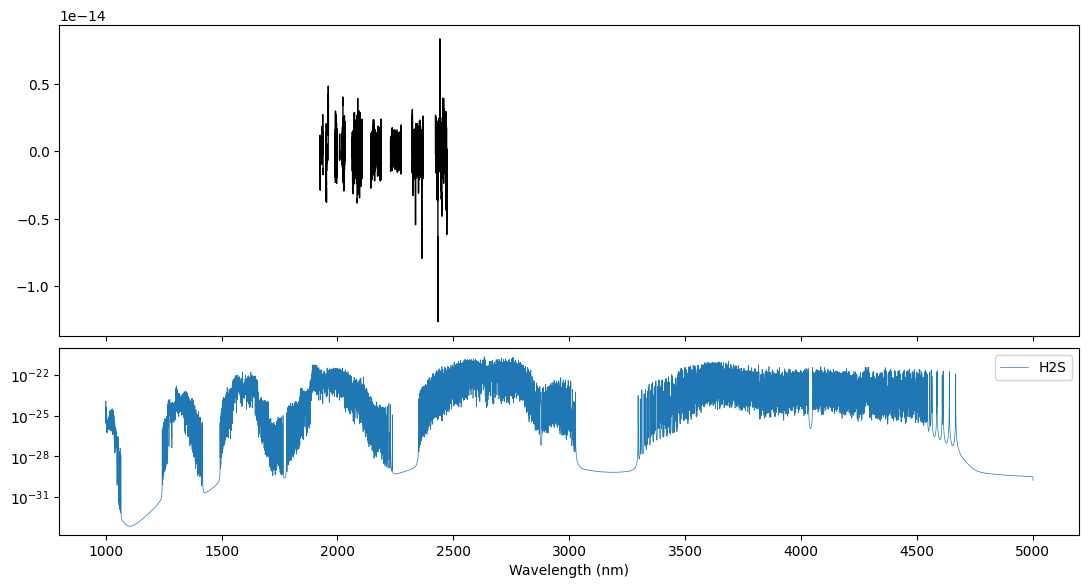

In [26]:
n = np.arange(6,100,1)
Pfund_lines = (1.0973731568160e7 * (1/25 - 1/n**2))**(-1) * 1e9

fig, ax = plt.subplots(
    figsize=(12,6), nrows=2, sharex=True, 
    gridspec_kw={'hspace':0.05, 'height_ratios':[1,0.6], 'left':0.1, 'right':0.95, 'top':0.95, 'bottom':0.1}
    )
ax_opa = ax[1]
ax = ax[0]
for i in range(d_spec_A.n_orders):
    for j in range(d_spec_B.n_dets):
        ax.plot(d_spec_A.wave[i,j], d_spec_A.flux[i,j] - m_spec_A.flux[i,j]*LogLike_A.f[i,j], c='k', lw=1)

#for line_i in Pfund_lines:
#    ax.axvline(line_i * (1+17/3e5), c='C1')

#ax_opa = ax.twinx()
#ylim = (1e-26,1e-16)
ylim = None
'''
ax_opa.plot(
    *opa_cross_sections(
        'H2O_pokazatel_main_iso', species_mass=2*1+16, 
        ), 
    lw=0.5, 
    )
ax_opa.plot(
    *opa_cross_sections(
        'CH4_hargreaves_main_iso', species_mass=4*1+12, 
        ), 
    lw=0.5, 
    )
ax_opa.plot(
    *opa_cross_sections(
        'NH3_coles_main_iso', species_mass=3*1+14, 
        ), 
    lw=0.5, 
    )
'''

'''
ax_opa.plot(
    *opa_cross_sections(
        'Ca', species_mass=40, 
        ), 
    lw=0.5, label='Ca'
    )
ax_opa.plot(
    *opa_cross_sections(
        'Ti', species_mass=48, 
        ), 
    lw=0.5, label='Ti'
    )
ax_opa.plot(
    *opa_cross_sections(
        'Fe', species_mass=56, 
        ), 
    lw=0.5, label='Fe'
    )
ax_opa.plot(
    *opa_cross_sections(
        'Na_allard', species_mass=23, 
        ), 
    lw=0.5, label='Na'
    )
ax_opa.plot(
    *opa_cross_sections(
        'K', species_mass=39, 
        ), 
    lw=0.5, label='K'
    )
#'''

'''
ax_opa.plot(
    *opa_cross_sections(
        'TiO_48_Exomol_McKemmish', species_mass=48+16, 
        ), 
    lw=0.5, label='TiO'
    )
ax_opa.plot(
    *opa_cross_sections(
        'FeH_main_iso', species_mass=56+1, 
        ), 
    lw=0.5, label='FeH'
    )
'''
ax_opa.plot(
    *opa_cross_sections(
        'H2S_main_iso', species_mass=2+32, 
        ), 
    lw=0.5, label='H2S'
    )
'''
ax_opa.plot(
    *opa_cross_sections(
        'HCN_main_iso', species_mass=1+16+14, 
        ), 
    lw=0.5, label='HCN'
    )
ax_opa.plot(
    *opa_cross_sections(
        'OH_main_iso', species_mass=16+1, 
        ), 
    lw=0.5, label='OH'
    )
ax_opa.plot(
    *opa_cross_sections(
        'CO2_main_iso', species_mass=2*16+12, 
        ), 
    lw=0.5, label='CO2'
    )
'''

'''
ax_opa.plot(
    *opa_cross_sections(
        'HF_main_iso', species_mass=1+19, 
        ), 
    lw=0.5, label='HF'
    )
'''

ax_opa.legend(ncol=3)
ax_opa.set(yscale='log', ylim=ylim, xlabel='Wavelength (nm)')

ax.set(
    #xlim=(d_spec_A.wave[-1].min()-0.1, d_spec_A.wave[-1].max()+0.1), 
    #xlim=(d_spec_A.wave[-2].min()-0.1, d_spec_A.wave[-2].max()+0.1), 
    #xlim=(d_spec_A.wave[-3].min()-0.1, d_spec_A.wave[-3].max()+0.1), 
    #xlim=(d_spec_A.wave[-3].min()-0.1, d_spec_A.wave[-1].max()+0.1), 
    )
plt.savefig('./plots/opa_cross_sec.pdf')
#plt.savefig('./plots/opa_cross_sec.png')
plt.show()